On s'interesse dans ce notebook à la modélisation de phénomènes physiques via une approche combiné ML + equation differentielle. En effet, modéliser un phénomène uniquement via des équations différentielles mène à des prédictions médiocres puisque nous ne pouvons modéliser tous les phénomènes physique ayant lieu et qu'il y a des erreurs numériques dans la résolution de ces dernières. Cependant, faire des prédictions uniquement basées sur du ML reviendrait à demander à un réseaux de neuronne de ré apprendre les équations de la physique dont on connait déjà une partie... Ainsi une approche ML + equadiff permet de tirer avantage de nos connaissances physique tout en laissant au réseau de neuronnes le soin d'apprendre les détails que l'on ne connait pas.

On s'interessera plus particulièrement dans ce notebook à l'exemple jouet suivant: on suppose que l'on observe des trajectoires (réalisées à partir de l'équation $\ddot x + a \dot x + b x = 0$) dont on connait un modèle physique médiocre (on suppose que l'on ne parvient pas à faire mieux que de proposer le modèle $\ddot x + b x = 0$ pour justifier nos observations...) mais malin comme nous somme on utilise un réseau de neuronne pour améliorer notre modèle (on cherche à trouver $\theta$ tel que $\ddot x + b x = F_{\theta}(x,\dot x, t) \ (*)$ soit une bonne modélisation du problème... (idéalement on veut donc que le réseau de neuronnes comprenne que $F_{\theta}(x,\dot x, t) = -a \dot x$))

La difficulté ici pour l'entrainement du réseau de neuronnes est de pouvoir calculer la dérivé de la solution de l'équation $(*)$ par rapport à $\theta$. Heureusement la bibliothèque JAX (https://docs.jax.dev/en/latest/index.html) fournit des outils pour calculer facilement des gradients via des méthodes d'autodiff (cf ce papier qui fait un tour d'horizon des méthodes de différenciation automatique implémentées dans JAX : https://arxiv.org/pdf/1502.05767). Il faut ensuite que le schéma d'intégration soit implémenté au dessus de JAX pour pouvoir bénéficier de toute la puissance de l'autodiff. C'est ce qui est fait dans la librairie Diffrax (https://docs.kidger.site/diffrax/). Enfin pour des raisons pratique on utilise FLAX (https://flax.readthedocs.io/en/stable/index.html) pour construire le réseau de neuronnes.

Le principe de ce que l'on fait ici est donc le même que celui utilisé dans https://arxiv.org/pdf/2311.07222 mais on a remplacé les observations météo par des trajectoires de $\ddot x + a \dot x + b x = 0$, nos connaissances des équations d'évolution de la météo par $\ddot x + b x = 0$ et le réseau de neuronnes utilisé par leur équipe par $F_{\theta}$...

Commençons par faire les imports necessaires:

In [1]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
from flax import nnx
import optax
from jax import random

key = jax.random.key(0)

jax.config.update("jax_platform_name", "cpu") #on se met sur cpu il n'y a pas de parallélisation massive ici
print(jax.default_backend())
print(jax.devices())

cpu
[CpuDevice(id=0)]


Ensuite on défini une équation différentielle qui nous permet de simuler un oscillateur avec force de rappel et frottements ($\ddot x + a \dot x + b x = 0$ ):

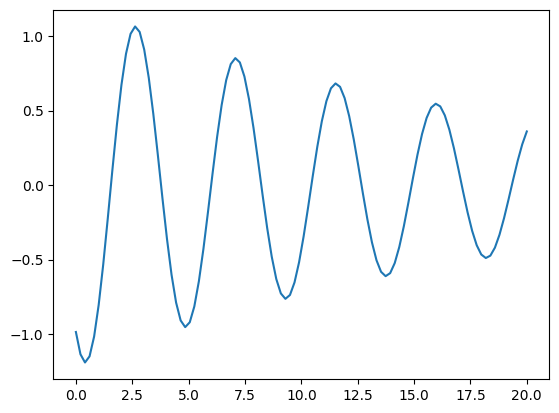

In [2]:
a = 0.1
b = 2.0

t0, tf = 0, 20
ts = jnp.linspace(t0, tf, 100)

solver = diffrax.Tsit5()

def solution(solver, f, t0, tf, ts, y0, args):
  return diffrax.diffeqsolve(
        diffrax.ODETerm(f),
        solver,
        t0=t0,
        t1=tf,
        dt0=0.1,
        y0=y0,
        saveat=diffrax.SaveAt(ts=ts),
        args=args
    ).ys[:, 0]

def f(t, y, args):
    a,b = args
    return jnp.array([y[1], -a * y[1] - b * y[0]])

key, subkey = jax.random.split(key)
y0 = (jax.random.uniform(subkey, shape=(2,)) - 0.5)*2

ys = solution(solver, f, t0, tf, ts, y0, (a,b))

plt.plot(ts, ys)
plt.show()

Cette équation différentielle va permettre de générer des "observations" d'un phénomème physique. Maintenant on va essayer de faire des prédictions sur la trajectoire suivie au cours du temps en ne connaissant que les conditions initiales. Pour cela on va construire le model suivant du phénomène : $\ddot x + b x = 0 $ (on fait comme si on ne connaissait pas le terme de frottement). Evidemment ce modèle n'est pas bon et ne permettra pas de faire de bonnes predictions !

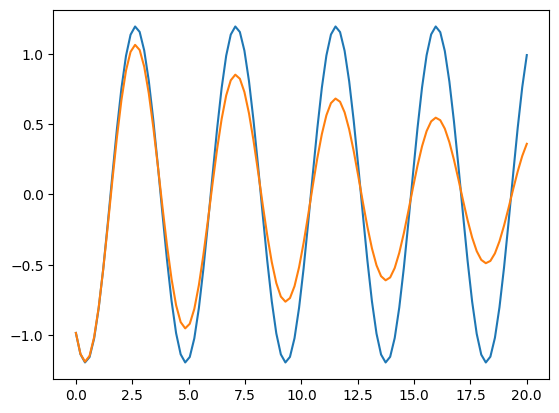

In [3]:
def f_modelSED(t, y, args): #SED pour seulement equation differentielle
    return jnp.array([y[1], - args * y[0]])

ys_modelSED = solution(solver, f_modelSED, t0, tf, ts, y0, b)

plt.plot(ts, ys_modelSED)
plt.plot(ts, ys)
plt.show()

Comme on peut le constater notre modèle se basant seulement sur une equation différentielle est de piètre qualité... on va essayer de changer les choses en intégrant un terme correctif qui sera un réseau de neuronne ($\ddot x + b x = F_{\theta}(x, \dot x, t)$).

On commence par définir un réseau de neuronnes simple:

In [4]:
class Model(nnx.Module):
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    return self.linear2(nnx.relu(self.linear1(x)))
  
model = Model(3, 64, 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3), wrt=nnx.Param)

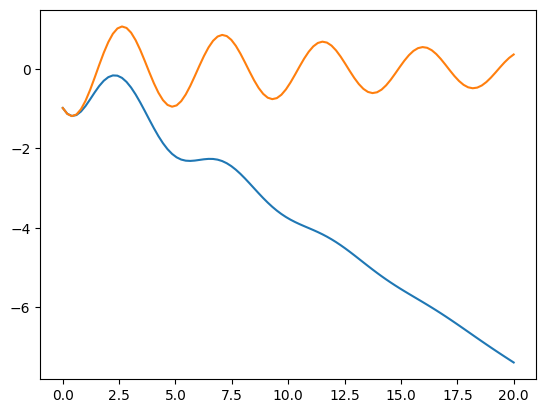

In [5]:

def f_modelEDML(t, y, args): #EDML pour equation differentielle + machine learning
    model, b = args
    return jnp.array([y[1], model(jnp.array([y[0], y[1], t])).squeeze() - b * y[0]])

ys_modelEDML = solution(solver, f_modelEDML, t0, tf, ts, y0, (model,b))

plt.plot(ts, ys_modelEDML)
plt.plot(ts, ys)
plt.show()

On peut voir que notre modèle fait n'importe quoi! C'est normal, on ne l'a pas encore entrainé. On va faire ça maintenant en répétant le processus suivant :
- Tirer des conditions initiales aléatoires $y0$
- Génerer une observation réelle pour ce $y0$ (via $f$)
- Génerer une prediction pour ce $y0$ (via $f\_modelEDML$)
- Calculer une loss qui mesure l'écart entre l'observation et la prediction
- Modifier les paramètres du model de manière à diminuer la loss

In [ ]:

@nnx.jit
def train_step(model, optimizer, y0, observation):
  def loss_fn(model):

    prediction = solution(solver, f_modelEDML, t0, tf, ts, y0, (model,b))

    return ((prediction - observation) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(model, grads)

  return loss

for i in range(2000):
  key, subkey = jax.random.split(key)
  y0 = (jax.random.uniform(subkey, shape=(2)) - 0.5)*2
  
  observation = solution(solver, f, t0, tf, ts, y0, (a,b))
  
  loss = train_step(model, optimizer, y0, observation)

  if i%1000==1000-1:
    print(loss)

2.217265e-05
4.789799e-05
5.3897597e-06
4.370126e-06
2.7079863e-05


Maintenant on peut tester notre modèle sur d'autres conditions initiales:

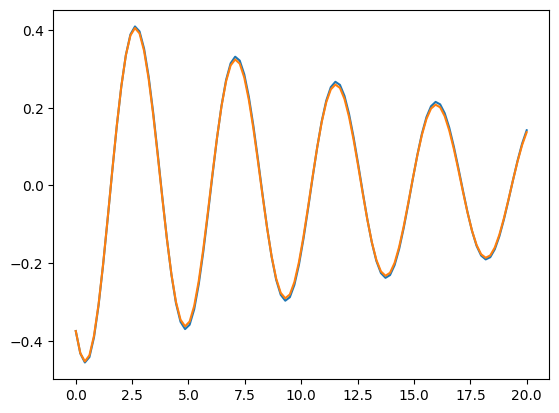

In [7]:
key, subkey = jax.random.split(key)
y0 = (jax.random.uniform(subkey, shape=(2)) - 0.5)*2

observation = solution(solver, f, t0, tf, ts, y0, (a,b))
prediction = solution(solver, f_modelEDML, t0, tf, ts, y0, (model, b))

plt.plot(ts, prediction)
plt.plot(ts, observation)
plt.show()

On peut constater que notre réseaux de neuronnes a bien compris que $F(x,\dot x, t) = -a \dot x$ ! Pour s'en assurer, on peut refaire des prédictions sur des temps et avec avec des conditions initialles non rencontrées jusque maintenant:

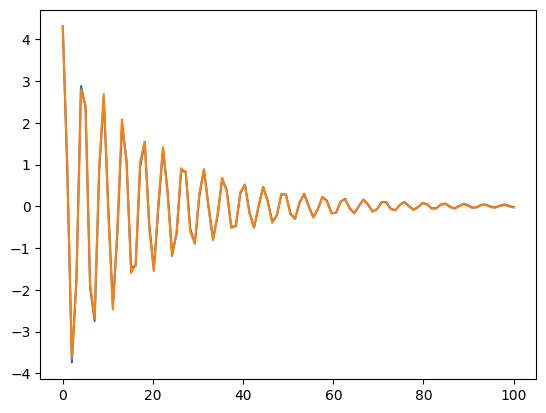

In [8]:
t0bis, tfbis = 0, 100
tsbis = jnp.linspace(t0bis, tfbis, 100)

key, subkey = jax.random.split(key)
y0 = jax.random.uniform(subkey, shape=(2))*5
  
observation = solution(solver, f, t0bis, tfbis, tsbis, y0, (a,b))
prediction = solution(solver, f_modelEDML, t0bis, tfbis, tsbis, y0, (model, b))

plt.plot(tsbis, prediction)
plt.plot(tsbis, observation)
plt.show()

Les résultats sont impressionnants même sur des situations non rencontrées jusque maintenant !